In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install -q itables contextily osmnx mapclassify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mapclassify import classify
import folium

from shapely.geometry import Point
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import networkx as nx
import osmnx as ox
import contextily as ctx

In [4]:
# Creating the map by joing neighborhoods
neighborhoods = gpd.read_file('/content/drive/MyDrive/Syracuse_Open_Data/Data/Neighborhoods_Delimitation_ShapeFile/Syracuse_Neighborhoods.shp')
neighborhoods = neighborhoods.to_crs("EPSG:4326")
neighborhoods_union = neighborhoods.geometry.unary_union
g = ox.graph_from_polygon(polygon = neighborhoods_union, network_type = 'all')
nodes_gdf, edges_gdf = ox.graph_to_gdfs(g)

In [102]:
def calculate_score(dataset, neighborhoods, buffer_distance):
  dataset = dataset.to_crs(neighborhoods.crs)
  dataset = dataset.to_crs(dataset.estimate_utm_crs())
  dataset['geometry'] = dataset['geometry'].buffer(buffer_distance)

  dataset = dataset.to_crs("EPSG:4326")
  neighborhoods = neighborhoods.to_crs("EPSG:4326")
  dataset_neighborhoods = gpd.sjoin(dataset, neighborhoods, how="left")

  dataset_with_score = dataset_neighborhoods.copy()
  dataset_with_score['score']=(dataset_with_score.groupby('Name').transform('size') / len(dataset))

  dataset_with_score = dataset_with_score.drop_duplicates(subset=['Name'])

  #final check so that all the neighborhoods are in the new dataframe. even though there is no occurance observed
  dataset_with_score = neighborhoods.merge(dataset_with_score[['Name', 'score']], on='Name', how='left')
  dataset_with_score['score'] = dataset_with_score['score'].fillna(0)

  return dataset_with_score[['Name', 'geometry', 'score']]

In [108]:
def display_map(dataset_with_score, neighborhoods):
  fig, ax = plt.subplots(figsize=(12, 12))

  dataset_with_score.plot(ax=ax, column='score', cmap = 'RdYlGn', legend = True)
  neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha = 0.2)
  ctx.add_basemap(ax, crs=dataset_with_score.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

  plt.show()

## CRIME DATA

In [103]:
crime1  = gpd.read_file('/content/drive/MyDrive/Syracuse_Open_Data/Data/Crime_Data_2023_-_Part_1_Offenses_(With_Lat_%26_Long_Info)/Crime_Data_2023_-_Part_1_Offenses_(With_Lat_%26_Long_Info).shp')
crime2  = gpd.read_file('/content/drive/MyDrive/Syracuse_Open_Data/Data/Crime_Data_2023_Part_2_Offenses_With_Lat_and_Long/Crime_Data_2023_Part_2_Offenses_With_Lat_and_Long.shp')

crime = pd.concat([crime1, crime2])

In [ ]:
crime

DATEEND TIMESTART  TIMEEND                        ADDRESS Arrest  \
0     2023-04-27      2021     2021               1 DESTINY USA DR   None   
1     2023-09-16      2002     2002  0 S CLINTON ST & W FAYETTE ST   None   
2     2023-12-01      1419     1427               1 DESTINY USA DR   None   
3     2023-06-10      1847     1847     0 S CROUSE AV & E ADAMS ST   None   
4     2023-08-24      1341     1341               1 DESTINY USA DR    Yes   
...          ...       ...      ...                            ...    ...   
6688  2023-12-22      2040     2040              1100 W  COLVIN ST    NaN   
6689  2023-12-22      2013     2103               600 CATHERINE ST    NaN   
6690  2023-12-22      2139     2139              500 S  CROUSE AVE    NaN   
6691  2023-12-22      1900     1905             1200 W  BELDEN AVE    NaN   
6692  2023-12-23       158      206                   100 ESSEX ST    NaN   

         LarcenyCod           CODE_DEFIN        LAT       LONG  ObjectId  \
0      Purse Snatch              LARCENY  43.067961 -76.173723         1   
1         All Other              LARCENY  43.048701 -76.153563         2   
2       Shoplifting              LARCENY  43.067961 -76.173723         3   
3     Motor Vehicle             MV THEFT  43.042671 -76.136647         4   
4       Shoplifting              LARCENY  43.067961 -76.173723         5   
...             ...                  ...        ...        ...       ...   
6688            NaN  OFFN AGAINST FAMILY  43.023215 -76.156986      6689   
6689            NaN       SIMPLE ASSAULT  43.056690 -76.144377      6690   
6690            NaN  OFFN AGAINST FAMILY  43.045315 -76.136669      6691   
6691            NaN    CRIMINAL MISCHIEF  43.054970 -76.173801      6692   
6692            NaN    CRIMINAL MISCHIEF  43.056810 -76.192899      6693   

                        geometry QualityOfL  
0     POINT (-76.17372 43.06796)        NaN  
1     POINT (-76.15356 43.04870)        NaN  
2     POINT (-76.17372 43.06796)        NaN  
3     POINT (-76.13665 43.04267)        NaN  
4     POINT (-76.17372 43.06796)        NaN  
...                          ...        ...  
6688  POINT (-76.15699 43.02322)      False  
6689  POINT (-76.14438 43.05669)      False  
6690  POINT (-76.13667 43.04531)      False  
6691  POINT (-76.17380 43.05497)      False  
6692  POINT (-76.19290 43.05681)       True  

[13326 rows x 12 columns]

In [106]:
crime_with_score = calculate_score(crime, neighborhoods, buffer_distance = 50)
display_map(crime_with_score, neighborhoods)

## PARKS DATA

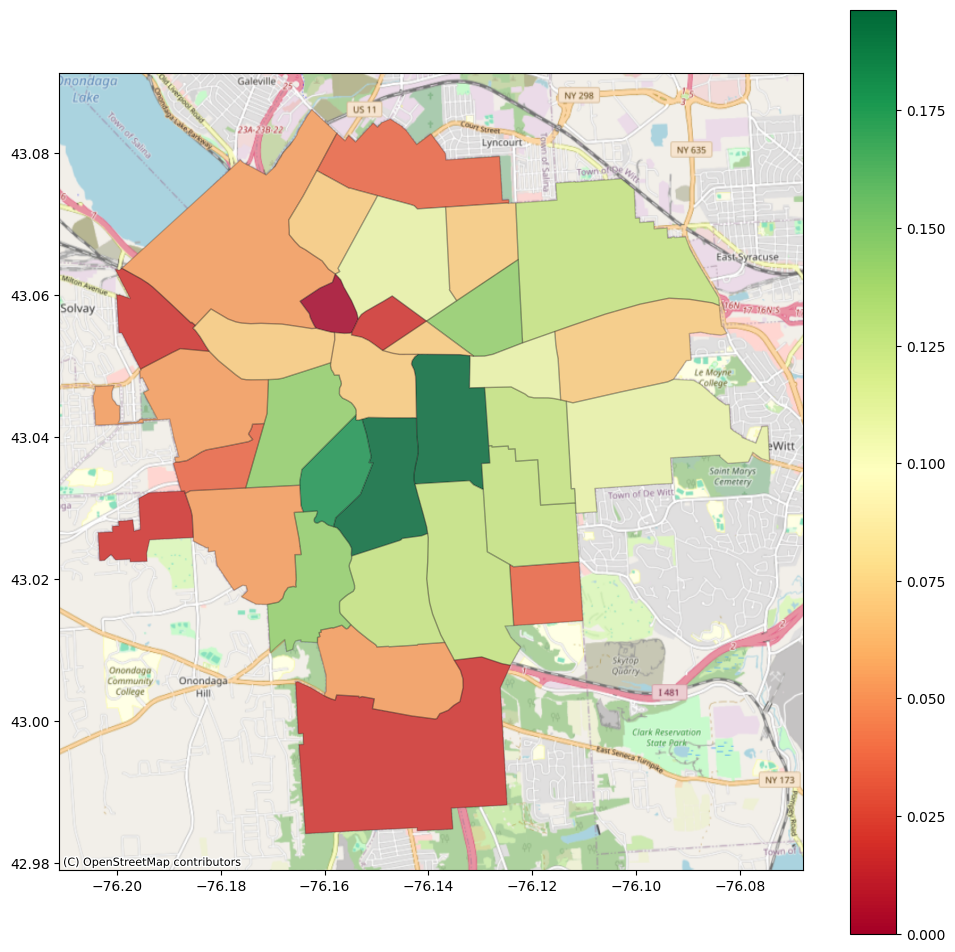

In [110]:
# Calculate of the score for parks

athletic_courts  = gpd.read_file('/content/drive/MyDrive/Syracuse_Open_Data/Data/Syracuse_s_Athletic_Courts/Syracuse_s_Athletic_Courts.shp')

athletic_courts_with_score = calculate_score(athletic_courts, neighborhoods, 500)
display_map(athletic_courts_with_score, neighborhoods)

## Join all datasets

In [112]:
athletic_courts_with_score.rename(columns={'score': 'score_athletic'}, inplace=True)
crime_with_score.rename(columns={'score': 'score_crime'}, inplace=True)

full_df = athletic_courts_with_score.merge(crime_with_score, on=['Name','geometry'])

In [113]:
full_df

Name  \
0                 Lakefront   
1            Court-Woodlawn   
2         Washington Square   
3                 Northside   
4                  Sedgwick   
5                  Eastwood   
6              Lincoln Hill   
7              Hawley-Green   
8           Franklin Square   
9             Prospect Hill   
10             Salt Springs   
11              Meadowbrook   
12             South Campus   
13  University Neighborhood   
14                 Westcott   
15            Near Eastside   
16          University Hill   
17           Outer Comstock   
18             North Valley   
19             South Valley   
20                 Brighton   
21                  Elmwood   
22                Southside   
23                Southwest   
24            Near Westside   
25                 Downtown   
26               Strathmore   
27                Winkworth   
28               Skunk City   
29                Tipp Hill   
30             Far Westside   
31                Park Ave.   

                                             geometry  score_athletic  \
0   POLYGON ((-76.16164 43.05533, -76.16248 43.055...        0.053571   
1   POLYGON ((-76.12449 43.07292, -76.12486 43.072...        0.035714   
2   POLYGON ((-76.14981 43.07401, -76.15019 43.073...        0.071429   
3   POLYGON ((-76.13670 43.07240, -76.13663 43.071...        0.107143   
4   POLYGON ((-76.12318 43.07296, -76.12313 43.072...        0.071429   
5   POLYGON ((-76.08395 43.05852, -76.08528 43.058...        0.125000   
6   POLYGON ((-76.12187 43.05327, -76.12759 43.051...        0.142857   
7   POLYGON ((-76.13125 43.05139, -76.13394 43.051...        0.071429   
8   POLYGON ((-76.15354 43.05663, -76.15431 43.055...        0.000000   
9   POLYGON ((-76.14882 43.05220, -76.15034 43.053...        0.017857   
10  POLYGON ((-76.09279 43.04813, -76.09389 43.047...        0.071429   
11  POLYGON ((-76.11159 43.02928, -76.11176 43.032...        0.107143   
12  POLYGON ((-76.12357 43.01347, -76.12434 43.021...        0.035714   
13  POLYGON ((-76.11168 43.03073, -76.11159 43.029...        0.125000   
14  POLYGON ((-76.11452 43.04524, -76.11343 43.045...        0.125000   
15  POLYGON ((-76.12920 43.04698, -76.13211 43.046...        0.107143   
16  POLYGON ((-76.12944 43.03265, -76.12962 43.032...        0.196429   
17  POLYGON ((-76.12422 43.00782, -76.12420 43.007...        0.125000   
18  POLYGON ((-76.13685 43.01109, -76.13531 43.009...        0.053571   
19  POLYGON ((-76.16014 43.00361, -76.15963 43.003...        0.017857   
20  POLYGON ((-76.15494 43.01357, -76.15549 43.014...        0.125000   
21  POLYGON ((-76.15480 43.02326, -76.15480 43.022...        0.142857   
22  POLYGON ((-76.14231 43.04271, -76.14225 43.040...        0.196429   
23  POLYGON ((-76.15279 43.04252, -76.15194 43.040...        0.178571   
24  POLYGON ((-76.15393 43.04314, -76.15463 43.042...        0.142857   
25  POLYGON ((-76.15883 43.05048, -76.15819 43.053...        0.071429   
26  POLYGON ((-76.18531 43.02586, -76.18533 43.026...        0.053571   
27  POLYGON ((-76.18686 43.03206, -76.18577 43.029...        0.017857   
28  POLYGON ((-76.17166 43.04190, -76.17522 43.032...        0.035714   
29  POLYGON ((-76.17084 43.04810, -76.17096 43.045...        0.053571   
30  POLYGON ((-76.18223 43.05208, -76.18781 43.052...        0.017857   
31  POLYGON ((-76.16164 43.05533, -76.15981 43.054...        0.071429   

    score_crime  
0      0.054705  
1      0.026415  
2      0.045925  
3      0.128471  
4      0.019060  
5      0.065736  
6      0.034144  
7      0.023413  
8      0.006078  
9      0.051403  
10     0.040372  
11     0.014633  
12     0.001726  
13     0.015459  
14     0.024689  
15     0.029641  
16     0.055456  
17     0.020561  
18     0.040822  
19     0.022587  
20     0.061609  
21     0.025814  
22     0.064010  
23     0.027315  
24     0.068813  
25     0.085922  
26     0.022813  
27     0.005403  
28     0.022813  
29     0.021087  
30     0.018460  
31     0.0366

In [114]:
full_df['total_score'] = full_df['score_athletic'] - full_df['score_crime']
full_df

Name  \
0                 Lakefront   
1            Court-Woodlawn   
2         Washington Square   
3                 Northside   
4                  Sedgwick   
5                  Eastwood   
6              Lincoln Hill   
7              Hawley-Green   
8           Franklin Square   
9             Prospect Hill   
10             Salt Springs   
11              Meadowbrook   
12             South Campus   
13  University Neighborhood   
14                 Westcott   
15            Near Eastside   
16          University Hill   
17           Outer Comstock   
18             North Valley   
19             South Valley   
20                 Brighton   
21                  Elmwood   
22                Southside   
23                Southwest   
24            Near Westside   
25                 Downtown   
26               Strathmore   
27                Winkworth   
28               Skunk City   
29                Tipp Hill   
30             Far Westside   
31                Park Ave.   

                                             geometry  score_athletic  \
0   POLYGON ((-76.16164 43.05533, -76.16248 43.055...        0.053571   
1   POLYGON ((-76.12449 43.07292, -76.12486 43.072...        0.035714   
2   POLYGON ((-76.14981 43.07401, -76.15019 43.073...        0.071429   
3   POLYGON ((-76.13670 43.07240, -76.13663 43.071...        0.107143   
4   POLYGON ((-76.12318 43.07296, -76.12313 43.072...        0.071429   
5   POLYGON ((-76.08395 43.05852, -76.08528 43.058...        0.125000   
6   POLYGON ((-76.12187 43.05327, -76.12759 43.051...        0.142857   
7   POLYGON ((-76.13125 43.05139, -76.13394 43.051...        0.071429   
8   POLYGON ((-76.15354 43.05663, -76.15431 43.055...        0.000000   
9   POLYGON ((-76.14882 43.05220, -76.15034 43.053...        0.017857   
10  POLYGON ((-76.09279 43.04813, -76.09389 43.047...        0.071429   
11  POLYGON ((-76.11159 43.02928, -76.11176 43.032...        0.107143   
12  POLYGON ((-76.12357 43.01347, -76.12434 43.021...        0.035714   
13  POLYGON ((-76.11168 43.03073, -76.11159 43.029...        0.125000   
14  POLYGON ((-76.11452 43.04524, -76.11343 43.045...        0.125000   
15  POLYGON ((-76.12920 43.04698, -76.13211 43.046...        0.107143   
16  POLYGON ((-76.12944 43.03265, -76.12962 43.032...        0.196429   
17  POLYGON ((-76.12422 43.00782, -76.12420 43.007...        0.125000   
18  POLYGON ((-76.13685 43.01109, -76.13531 43.009...        0.053571   
19  POLYGON ((-76.16014 43.00361, -76.15963 43.003...        0.017857   
20  POLYGON ((-76.15494 43.01357, -76.15549 43.014...        0.125000   
21  POLYGON ((-76.15480 43.02326, -76.15480 43.022...        0.142857   
22  POLYGON ((-76.14231 43.04271, -76.14225 43.040...        0.196429   
23  POLYGON ((-76.15279 43.04252, -76.15194 43.040...        0.178571   
24  POLYGON ((-76.15393 43.04314, -76.15463 43.042...        0.142857   
25  POLYGON ((-76.15883 43.05048, -76.15819 43.053...        0.071429   
26  POLYGON ((-76.18531 43.02586, -76.18533 43.026...        0.053571   
27  POLYGON ((-76.18686 43.03206, -76.18577 43.029...        0.017857   
28  POLYGON ((-76.17166 43.04190, -76.17522 43.032...        0.035714   
29  POLYGON ((-76.17084 43.04810, -76.17096 43.045...        0.053571   
30  POLYGON ((-76.18223 43.05208, -76.18781 43.052...        0.017857   
31  POLYGON ((-76.16164 43.05533, -76.15981 43.054...        0.071429   

    score_crime  total_score  
0      0.054705    -0.001134  
1      0.026415     0.009300  
2      0.045925     0.025503  
3      0.128471    -0.021328  
4      0.019060     0.052368  
5      0.065736     0.059264  
6      0.034144     0.108713  
7      0.023413     0.048016  
8      0.006078    -0.006078  
9      0.051403    -0.033546  
10     0.040372     0.031056  
11     0.014633     0.092510  
12     0.001726     0.033988  
13     0.015459     0.109541  
14     0.024689     0.100311  
15     0.029641     0.077502  
16     0.055456     0.140973  
17     0.020561     0.104439  


## Export file

In [115]:
# full_df.to_file("/content/drive/MyDrive/Syracuse_Open_Data/Export_Zerin/df_with_scores.shp")

<ipython-input-115-8ea9e111c52c>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  full_df.to_file("/content/drive/MyDrive/Syracuse_Open_Data/Export_Zerin/df_with_scores.shp")


In [116]:
m = folium.Map([43.0481, -76.1474], zoom_start=12)

folium.Choropleth(
    geo_data=full_df,
    name="choropleth",
    data=full_df,
    columns=["Name", "total_score"],  # specify both the ID and the score column
    key_on="feature.properties.Name",  # match the neighborhood ID in your GeoJSON
    fill_color="RdYlGn",
    fill_opacity=0.8,
    line_weight=2
).add_to(m)

folium.GeoJson(
    full_df,
    name="Neighborhoods",
    tooltip=folium.GeoJsonTooltip(
        fields=["Name", "total_score"],
        aliases=["Neighborhood:", "Score:"],
        localize=True
    )
).add_to(m)

m
